# Use CNN to detect breast cancer 

In [1]:
# General packages
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import random

from matplotlib.image import imread
import cv2

# Packages for ML
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
# from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D


In [2]:
fd = '../ECE 228/archive/IDC_regular_ps50_idx5'

imagePatches = glob(fd + '/**/*.png', recursive=True)
for filename in imagePatches[0:5]:
    print(filename)

../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png


In [3]:
len(imagePatches)

277524

In [4]:
# bin the data to cancer and no cancer

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

display('Size of the class 0 = ',len(class0))
display('Size of the class 1 = ',len(class1))

'Size of the class 0 = '

198738

'Size of the class 1 = '

78786

In [5]:
class0[100]

'../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2201_y1051_class0.png'

In [6]:
# randomly select 1000 images from each class

num_sample_selected = 50000
rand_sample_class0 = random.sample(class0, num_sample_selected)
rand_sample_class1 = random.sample(class1, num_sample_selected)


In [7]:
rand_sample_class1[100]

'../ECE 228/archive/IDC_regular_ps50_idx5/15633/1/15633_idx5_x1451_y151_class1.png'

In [8]:
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = imread(i )
            img_sized = cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [9]:
class0_array = get_image_arrays(rand_sample_class0, 0)
class1_array = get_image_arrays(rand_sample_class1, 1)

In [10]:
len(class0_array)

50000

(50, 50, 3)

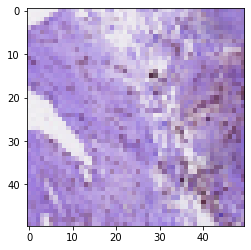

In [11]:
test = cv2.imread(fd + '/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
plt.imshow(test)

display(test.shape)

In [12]:
# combine the class 0 and class 1 data
combined_data = np.concatenate((class0_array, class1_array))

# array of index for shuffling
idx_arr = list(range(combined_data.shape[0]))

random.seed(10)

random.shuffle(idx_arr)

# shuffled data
combined_data = combined_data[idx_arr,:]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(array([50000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 50000.]),
 array([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001,
        0.7000000000000001, 0.8, 0.9, 1.0], dtype=object),
 <BarContainer object of 10 artists>)

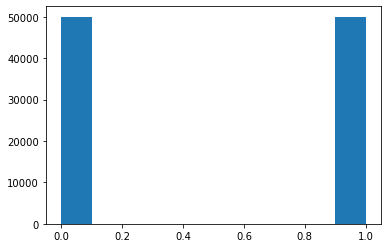

In [13]:
plt.hist(combined_data[:,1])

In [14]:
X = []
y = []

for i in range(combined_data.shape[0]):
    X.append(combined_data[i][0])
    y.append(combined_data[i][1])



In [15]:
X = np.array(X).reshape(-1, 64, 64, 3)

In [16]:
print(torch.cuda.is_available())

False


In [17]:
X.shape

(100000, 64, 64, 3)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75000, 64, 64, 3) (25000, 64, 64, 3) (75000, 2) (25000, 2)


In [19]:
def model_1():        
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 16, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation="softmax"))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    #model.compile(loss="MeanSquaredError", optimizer=adam, metrics=['accuracy'])     


    return model

def model_2():        
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation="softmax"))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    #model.compile(loss="MeanSquaredError", optimizer=adam, metrics=['accuracy'])     


    return model

In [20]:
model = model_1()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 10,
    verbose = 2,
)

2022-05-23 15:15:21.180024: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2344/2344 - 425s - loss: 0.6113 - accuracy: 0.7687 - val_loss: 0.5790 - val_accuracy: 0.7989 - 425s/epoch - 181ms/step
Epoch 2/10
2344/2344 - 432s - loss: 0.5677 - accuracy: 0.7893 - val_loss: 0.5481 - val_accuracy: 0.7976 - 432s/epoch - 184ms/step
Epoch 3/10
2344/2344 - 437s - loss: 0.5325 - accuracy: 0.8014 - val_loss: 0.5144 - val_accuracy: 0.8082 - 437s/epoch - 186ms/step
Epoch 4/10
2344/2344 - 568s - loss: 0.5028 - accuracy: 0.8102 - val_loss: 0.4886 - val_accuracy: 0.8151 - 568s/epoch - 242ms/step
Epoch 5/10
2344/2344 - 448s - loss: 0.4788 - accuracy: 0.8165 - val_loss: 0.4718 - val_accuracy: 0.8158 - 448s/epoch - 191ms/step
Epoch 6/10
2344/2344 - 459s - loss: 0.4562 - accuracy: 0.8244 - val_loss: 0.4426 - val_accuracy: 0.8304 - 459s/epoch - 196ms/step
Epoch 7/10
2344/2344 - 449s - loss: 0.4353 - accuracy: 0.8323 - val_loss: 0.4301 - val_accuracy: 0.8315 - 449s/epoch - 191ms/step
Epoch 8/10
2344/2344 - 470s - loss: 0.4185 - accuracy: 0.8378 - val_loss: 0.4139 - val_acc

In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 1,
    verbose = 2,
)

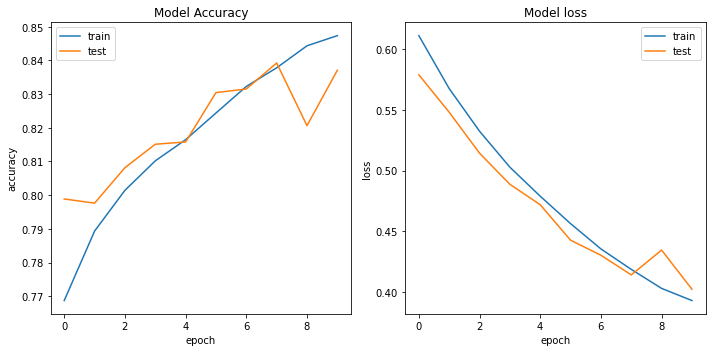

In [21]:
fig, axs = plt.subplots(1,3,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

fig.tight_layout()
plt.show()

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])